In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import minimize
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [2]:
#First we download the data and transform it into returns the sample period spants beginning of 2018 to the end of 2023
data_raw = yf.download("WMT AMZN COST SPY", start="2018-01-03", end="2023-12-31")
data_raw = data_raw.iloc[: , :4]
data_raw.columns = ['WMT', 'AMZN', 'COST', 'SPY']

daily_ret = data_raw.pct_change()
daily_ret

[*********************100%%**********************]  4 of 4 completed


,WMT,AMZN,COST,SPY
Date,,,,
2018-01-03,NaN,NaN,NaN,NaN
2018-01-04,0.004476,-0.007765,0.004215,0.000905
2018-01-05,0.016163,-0.007139,0.006664,0.005927
2018-01-08,0.014425,0.003888,0.001829,0.014781
2018-01-09,0.004676,-0.011619,0.002264,-0.012006
...,...,...,...,...
2023-12-22,-0.002730,0.009682,0.002010,0.011951
2023-12-26,-0.000065,0.004497,0.004223,-0.001532
2023-12-27,-0.000456,0.010885,0.001808,0.009398


In [3]:
#calculate the expected return, variance, standard deviation, and the covariance matrix based on the data above. 
#and combine it into a simple dataframe sum_stats
sum_stats = {'Mean':daily_ret.mean()*252,
        'Var': daily_ret.var()*252,
        'Std': daily_ret.std()*(252**0.5)}
sum_stats = pd.DataFrame(sum_stats)
print(sum_stats)

          Mean       Var       Std
WMT   0.217358  0.125138  0.353748
AMZN  0.252036  0.055283  0.235123
COST  0.131998  0.041592  0.203940
SPY   0.120008  0.050182  0.224012


In [4]:
#covariance matrix:
cov_mat = daily_ret.cov()*252
print(cov_mat)

           WMT      AMZN      COST       SPY
WMT   0.125138  0.042070  0.047771  0.024101
AMZN  0.042070  0.055283  0.030790  0.031908
COST  0.047771  0.030790  0.041592  0.021234
SPY   0.024101  0.031908  0.021234  0.050182


# Part 1

In [5]:
#First we define a given portfolio weight
weight = [0.25 ,0.25 ,0.25 ,0.25]

#Using the weight we can calculate the expected portfolio return and risk:
portfolio_stats = np.array([weight@(sum_stats.Mean), (weight@cov_mat@weight)**0.5])
print('Portfolio expected return is:', portfolio_stats[0], 'and Portfolio risk is:', portfolio_stats[1])

Portfolio expected return is: 0.18035020648543532 and Portfolio risk is: 0.20431915749429852


<Axes: xlabel='risk', ylabel='ret'>

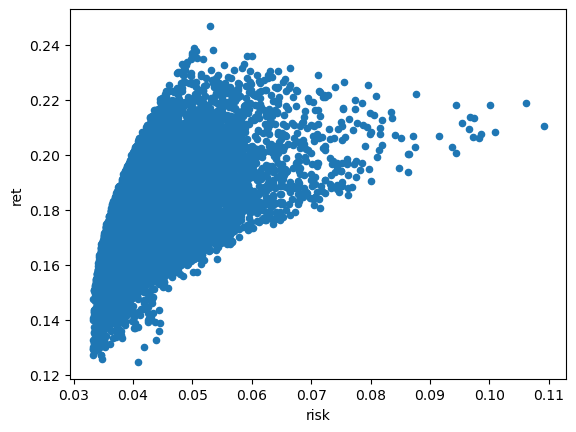

In [6]:
#Generate a large number of random weights:
#np.random.seed(1)
weight = np.random.rand(10000, 4)
weight = pd.DataFrame(weight)
    
weight.columns = ['w1', 'w2', 'w3','w4']
weight['w_sum'] = weight['w1'] + weight['w2'] +weight['w3']+ weight['w4']
weight['w1'] = weight['w1']/weight['w_sum']
weight['w2'] = weight['w2']/weight['w_sum']
weight['w3'] = weight['w3']/weight['w_sum']
weight['w4'] = weight['w4']/weight['w_sum']

weight = weight.iloc[: , :4]

#calculate return and risk for all these random portfolios:

weight = np.array(weight)
asset_ret = np.array(sum_stats.Mean)

port_ret = weight.dot(asset_ret)
port_std = np.diag(weight@cov_mat@weight.T)

#Let's put the portfolio return, risk, and the weight of the assets in one dataframe: 
portfolios = pd.DataFrame({'ret':port_ret, 'risk':port_std})
weight = pd.DataFrame(weight)
weight.columns = ['w1', 'w2', 'w3','w4']
portfolios = portfolios.join(weight)

#plot the scatter graph
portfolios.plot('risk', 'ret', kind='scatter')

In [7]:
portfolios.rename(columns={'w1': 'WMT', 'w2': 'AMZN', 'w3': 'COST', 'w4': 'SPY'}, inplace=True)
portfolios

,ret,risk,WMT,AMZN,COST,SPY
0,0.174361,0.037204,0.083745,0.333071,0.185604,0.397580
1,0.173897,0.035389,0.007021,0.367836,0.387070,0.238073
2,0.205160,0.049088,0.338051,0.386198,0.104544,0.171206
3,0.194377,0.044978,0.289831,0.337183,0.136470,0.236516
4,0.173238,0.040107,0.215811,0.231579,0.137229,0.415381
...,...,...,...,...,...,...
9995,0.199223,0.041130,0.137411,0.488038,0.117015,0.257536
9996,0.161443,0.037114,0.149923,0.163681,0.436103,0.250293
9997,0.176698,0.047267,0.366770,0.140593,0.202016,0.290621
9998,0.215515,0.051285,0.327161,0.468975,0.145114,0.058750


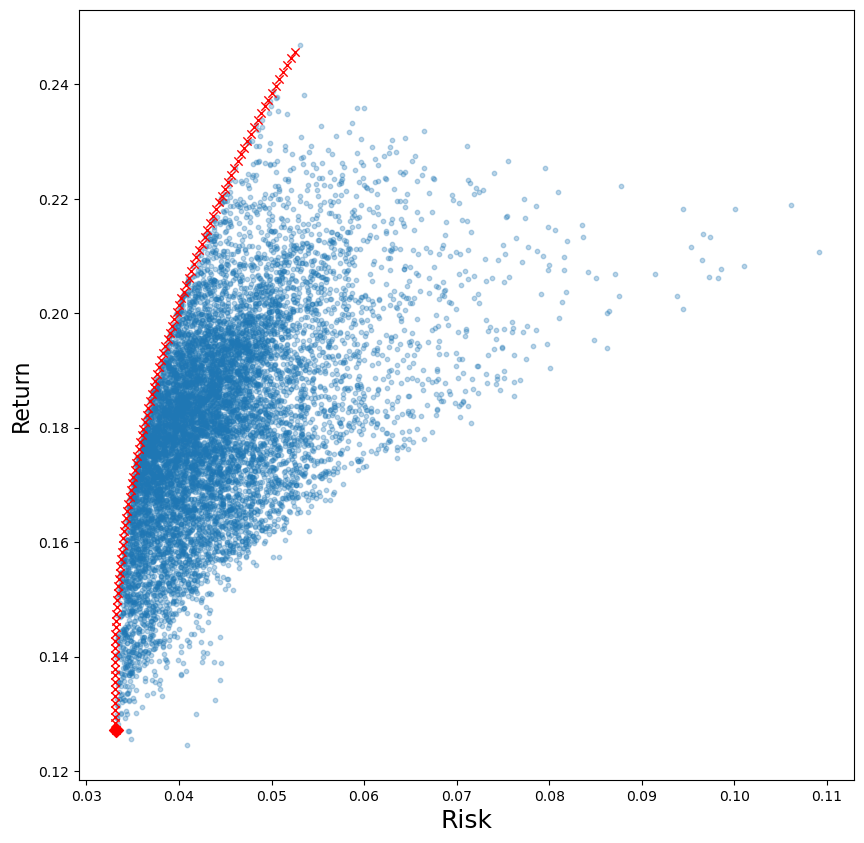

In [8]:
#first we generate the "grids" over portfolio returns:
#we want to calculate the minimum variance for all the point on the grids of portfolio returns,
#starting from the return of the portfolio with minimum variance

min_var_ret = portfolios.loc[portfolios[['risk']].idxmin(), 'ret']
min_var_risk = portfolios.loc[portfolios[['risk']].idxmin(), 'risk']
min_var_ret = np.array(min_var_ret)

eff_ret = np.arange(min_var_ret, portfolios.ret.max(), 
                  (portfolios.ret.max()-min_var_ret)/100)
eff_risk = np.zeros(len(eff_ret))


#then we can use the minimize function over each point on "eff_risk":
#e = 1e-10 #we create a very small positive real number here
cov_mat = np.array(cov_mat)
f = lambda x: x@cov_mat@x.T
x0 = np.array((0.25, 0.25, 0.25, 0.25)) #set the initial value of x, y, z

for ind in range(len(eff_ret)):
    #set the optimization problem constraints:
    cons = ({'type':'eq','fun':lambda x:x[0] + x[1] + x[2] + x[3] - 1},  #constraint：x+y+z+a = 1
        {'type':'eq','fun':lambda x:x@asset_ret - eff_ret[ind]},    #constraint: set the return of the portfolio to be constant
        {'type':'ineq','fun':lambda x:x[0] },                  #constraint: x,y,z > 0
        {'type':'ineq','fun':lambda x:x[1] },
        {'type':'ineq','fun':lambda x:x[2] },
        {'type':'ineq','fun':lambda x:x[3] })
    
    #find the minimum variance of the portfolio given certain return level
    res = minimize(f, x0, constraints=cons)
    eff_risk[ind] = res.fun
    #print(eff_y)

#now the eff_x and eff_y describe the risk and return combination on the efficient frontier.
#let's plot the efficient frontier:

plt.subplots(figsize=[10,10])
plt.xlabel('Risk', fontsize=18)
plt.ylabel('Return', fontsize=16)
plt.scatter(portfolios['risk'], portfolios['ret'],marker='o', s=10, alpha=0.3)
plt.scatter(min_var_risk, min_var_ret, color='r', marker='D', s=50)
plt.scatter(eff_risk, eff_ret, color='r', marker='x', linestyle='-', linewidth=1)

In [9]:
#check the GMv portfolio statistics and which index it corresponds to
print("min variance return",min_var_ret)
print("min variance return",min_var_risk)

x=min_var_risk
print(x)

min variance return [0.12712158]
min variance return 9575    0.033229
Name: risk, dtype: float64
9575    0.033229
Name: risk, dtype: float64


In [10]:
#We then search for the index within the portfolio dataframe to find the weights composition
value_to_find = x

#Set the tolerance for approximate matches
tolerance = 0.00001  # Adjust as needed

#Check for approximate matches within the specified tolerance
filtered_df = portfolios[np.isclose(portfolios['risk'], value_to_find, atol=tolerance)]

#Check if any matches were found
if not filtered_df.empty:
    index1 = filtered_df.index[0]  # Get the index of the first match
    print("Found at index:", index1)
else:
    print("No approximate match found.")

Found at index: 9575


In [11]:
index1

9575

# Answer to Part 1 Min variance portfolio

In [12]:
row_index1 = portfolios.loc[index1]
print("Row corresponding to index min var:\n", row_index1)

Row corresponding to index min var:
 ret     0.127122
risk    0.033229
WMT     0.002202
AMZN    0.001311
COST    0.560962
SPY     0.435525
Name: 9575, dtype: float64


In [13]:
#From the previous randomly generated portfolios, we want to find the tangency portfolio
#That is still Monte Carlo Method

rf = 0.015
portfolios['sr'] = (portfolios['ret'] - rf)/portfolios['risk']
#print(portfolios)

#Find the maximum sharpe ratio, and the tangency portfolio
max_sr = portfolios[['sr']].max().to_numpy() #make the value a single number but not a dataframe;
tp_ret = portfolios.loc[portfolios[['sr']].idxmax(), 'ret']
tp_risk = portfolios.loc[portfolios[['sr']].idxmax(), 'risk']
Optimal_risky_SR=max_sr

In [14]:
#We then search for the index within the portfolio dataframe to find the maximum Sharpe ratio portfolio
value_to_find = Optimal_risky_SR

#Set the tolerance for approximate matches
tolerance = 0.000000001  # Adjust as needed

#Check for approximate matches within the specified tolerance
filtered_df = portfolios[np.isclose(portfolios['sr'], value_to_find, atol=tolerance)]

#Check if any matches were found
if not filtered_df.empty:
    index2 = filtered_df.index[0]  # Get the index of the first match
    print("Found at index:", index2)
else:
    print("No approximate match found.")

Found at index: 6941


# Answer Part 2 composition of the optimal risky portfolio

In [15]:
#We Locate the Optimal risky portfolio (highest sharpe ratio)
row_index2 = portfolios.loc[index2]
print("Row corresponding to index max SR:\n", row_index2)

Row corresponding to index max SR:
 ret     0.206081
risk    0.041026
WMT     0.007308
AMZN    0.623072
COST    0.258421
SPY     0.111198
sr      4.657510
Name: 6941, dtype: float64


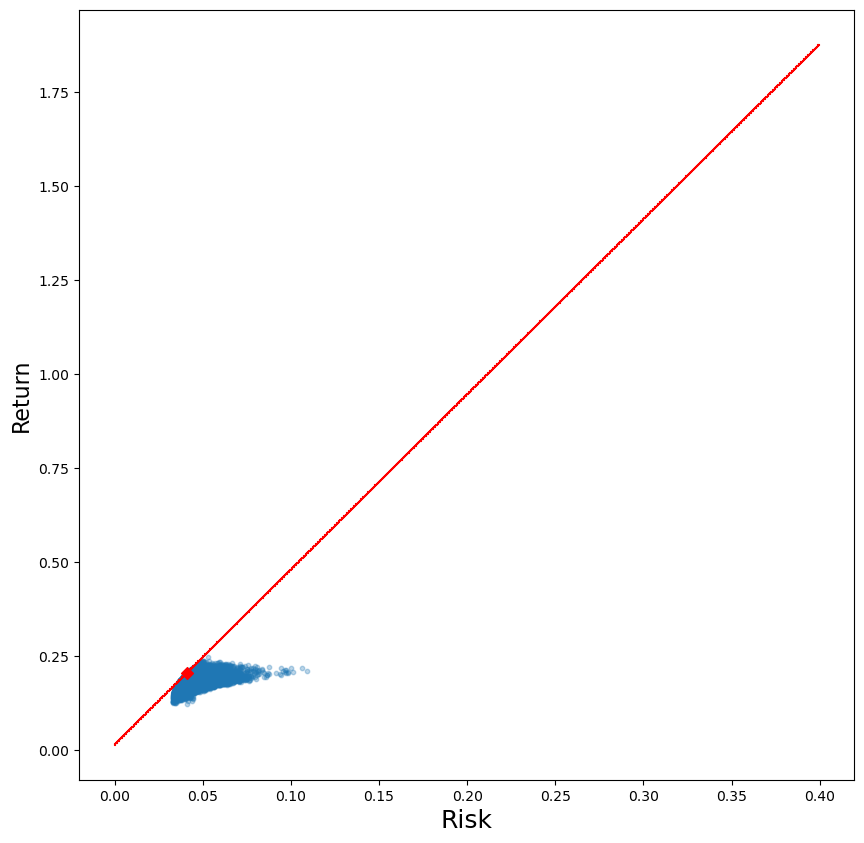

In [16]:
#generate different combinations of risk free asset and tangency portfolio
cml_x = np.arange(0, 0.4, 0.4/1000)
cml_y = rf + max_sr*cml_x


#draw the portfolios and the capital market line
plt.subplots(figsize=[10,10])
plt.xlabel('Risk', fontsize=18)
plt.ylabel('Return', fontsize=16)
plt.scatter(portfolios['risk'], portfolios['ret'], marker='o', s=10, alpha=0.3)
plt.scatter(tp_risk, tp_ret, color='r', marker='D')
plt.scatter(cml_x, cml_y, color='r', marker='+', s=3)

In [17]:
#To be able to back out the investors allocation in the risk free asset we need to assume risk aversion parameter A
A= 4

# Assuming you've already identified this index
risk_value = portfolios.loc[index2, 'risk']
return_value = portfolios.loc[index2, 'ret']

#Weight of risky portfolio can be calculated when combining with a risk free asset
weight_risky= (return_value-rf)/ (A *risk_value)
weight_rf= 1-weight_risky
print("Weight in the risky asset:",weight_risky)
print("Weight in the risk free:",weight_rf)

Weight in the risky asset: 1.1643773910304025
Weight in the risk free: -0.1643773910304025
